<a href="https://colab.research.google.com/github/h-wi/2022F-Ajou-ML/blob/main/baseline_for_final_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge :: Coin Classification

#Update Validation Dataset, Early stopping & tuning with Random search or optuna?

여러 나라의 동전 이미지를 보고 어느 나라의 동전인지 분류하는 테스크입니다.  
동전의 클래스는 인도, 유럽, 중국, 미국, 일본, 필리핀으로 총 6개 입니다.

각 나라의 label은 아래와 같이 설정합니다.
{'china_coins': 0,
 'euro_coins': 1,
 'indian_coins': 2,
 'peso_coins': 3,
 'us_coins': 4,
 'yen_coins': 5}

## Drive에서 데이터 가져오기 OR 로컬에서 파일 업로드

In [216]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
cd /content/drive/MyDrive/TEST-20221111T124821Z-001/TEST

/content/drive/MyDrive/TEST-20221111T124821Z-001/TEST


In [218]:
rm prediction_result.csv

## Load Data 

In [219]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
import torch.utils.data

In [220]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

In [221]:
image_transforms = {  #data normalization
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.6636642,0.6325669, 0.5912429], [0.21439965,0.22245239, 0.23941268]) 
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.6636642,0.6325669, 0.5912429], [0.21439965,0.22245239, 0.23941268])  
    ])
}

In [222]:
# From https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [223]:
#from https://dacon.io/en/codeshare/4750

def get_mean_std(data_dir):
    '''
    이미지 정규화 시 성능 향상 , 평균과 표준편차로 정규화 실행
    data_dir = 이미지 들어있는 폴더 path
    '''
    transform = transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(os.path.join(f'{data_dir}'), transform)
    print("데이터 정보", dataset)

    meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in dataset]
    stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])
    print("평균",meanR, meanG, meanB)
    print("표준편차",stdR, stdG, stdB)

In [224]:
# get_mean_std(data_dir_load)

In [225]:
data_dir_load = "/content/drive/MyDrive/TRAIN-20221111T124823Z-001/TRAIN"
train_data = ImageFolderWithPaths(data_dir_load, # load train data
                                   transform = image_transforms['train'],
                                  )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True) # make train loader

In [226]:
train_data

Dataset ImageFolderWithPaths
    Number of datapoints: 1229
    Root location: /content/drive/MyDrive/TRAIN-20221111T124823Z-001/TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.6636642, 0.6325669, 0.5912429], std=[0.21439965, 0.22245239, 0.23941268])
           )

In [227]:
classes = train_data.class_to_idx # class name
classes

{'china_coins': 0,
 'euro_coins': 1,
 'indian_coins': 2,
 'peso_coins': 3,
 'us_coins': 4,
 'yen_coins': 5}

## Show Example Data

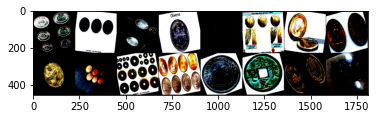


china_coins yen_coins peso_coins yen_coins yen_coins peso_coins euro_coins us_coins indian_coins euro_coins china_coins indian_coins china_coins china_coins yen_coins peso_coins


In [228]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
# print(dataiter.next())
images, labels, paths = dataiter.next()

batch_size = 16 
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print()
labels = labels.tolist()
print(' '.join(f'{list(classes.keys())[list(classes.values()).index(j)]}' for j in labels))

## Define a Convolutional Neural Network 

In [229]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, 
                     bias=False)

In [230]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [231]:
class Bottleneck(nn.Module):
    expansion = 4 # 병목 블록을 정의하기 위한 하이퍼파라미터

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes) # 1x1 합성곱층
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [232]:
#from https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
#from https://github.com/heartcored98/Standalone-DeepLearning/blob/master/Lec6/Assignment5_CIFAR-100_with_ResNet.ipynb

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [233]:
import copy
from collections import namedtuple
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [234]:
resnet34_config = ResNetConfig(block=BasicBlock,
                             n_blocks=[3, 4, 6, 3,],
                             channels=[64, 128, 256, 512]) #basic block 사용

resnet50_config = ResNetConfig(block=Bottleneck,
                             n_blocks=[3, 4, 6, 3],
                             channels=[64,128,256,512]) #bottleneck block 사용

resnet101_config = ResNetConfig(block=Bottleneck,
                             n_blocks=[3,4,23,3],
                             channels=[64,128,256,512]) #bottleneck block 사용, 좀 더 깊다

In [235]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available # colab 런타임 유형 변경에서 GPU 선택할 것

In [236]:
net = ResNet(resnet50_config.block,resnet50_config.n_blocks,len(classes)) # define the network 
net = net.to(device) # send the network to the device

In [237]:
import numpy as np
from torchsummary import summary
summary(net, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Define a Loss function and optimizer 

In [238]:
from torch.optim import Adam, lr_scheduler

criterion = nn.CrossEntropyLoss(reduction='sum').to(device) # loss function, 변경 가능

optimizer = optim.SGD(net.parameters(), lr=0.001)#, momentum=0.9, weight_decay = 0.0001) # SGD optimizer, 변경 가능

# optimizer = Adam(net.parameters(), lr=0.001, weight_decay=0.0001) #L2 REGULARIZATION

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

## Train the Network 

In [239]:
for epoch in range(20):  # loop over the dataset multiple times, 10 or 15

    net.train()
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, 0)):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, paths = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training') # epoch이 50일 때, training acc 46% 달성

  0%|          | 0/77 [00:00<?, ?it/s]

[1,    50] loss: 1.777


  0%|          | 0/77 [00:00<?, ?it/s]

[2,    50] loss: 1.029


  0%|          | 0/77 [00:00<?, ?it/s]

[3,    50] loss: 0.892


  0%|          | 0/77 [00:00<?, ?it/s]

[4,    50] loss: 0.807


  0%|          | 0/77 [00:00<?, ?it/s]

[5,    50] loss: 0.778


  0%|          | 0/77 [00:00<?, ?it/s]

[6,    50] loss: 0.744


  0%|          | 0/77 [00:00<?, ?it/s]

[7,    50] loss: 0.720


  0%|          | 0/77 [00:00<?, ?it/s]

[8,    50] loss: 0.725


  0%|          | 0/77 [00:00<?, ?it/s]

[9,    50] loss: 0.700


  0%|          | 0/77 [00:00<?, ?it/s]

[10,    50] loss: 0.695


  0%|          | 0/77 [00:00<?, ?it/s]

[11,    50] loss: 0.683


  0%|          | 0/77 [00:00<?, ?it/s]

[12,    50] loss: 0.678


  0%|          | 0/77 [00:00<?, ?it/s]

[13,    50] loss: 0.668


  0%|          | 0/77 [00:00<?, ?it/s]

[14,    50] loss: 0.651


  0%|          | 0/77 [00:00<?, ?it/s]

[15,    50] loss: 0.665


  0%|          | 0/77 [00:00<?, ?it/s]

[16,    50] loss: 0.636


  0%|          | 0/77 [00:00<?, ?it/s]

[17,    50] loss: 0.646


  0%|          | 0/77 [00:00<?, ?it/s]

[18,    50] loss: 0.638


  0%|          | 0/77 [00:00<?, ?it/s]

[19,    50] loss: 0.632


  0%|          | 0/77 [00:00<?, ?it/s]

[20,    50] loss: 0.634
Finished Training


## Save the Network commented

In [240]:
# #save the trained model
# PATH = './net_pretrained.pth'
# torch.save(net.state_dict(), PATH)

## Load the Network commented

In [241]:
#net = Net()
#net.load_state_dict(torch.load(PATH))

## Calculate Training accuracy

In [242]:
train_test_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False) # make train_test loader

In [243]:
correct = 0
total = 0

net.eval() #dropout false

image_id = []
predicted_label = []
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for i, data in enumerate(tqdm(train_test_loader,0)):
        images, labels, paths = data
        
        images = images.to(device)
        labels = labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        image_id.append(paths)
        predicted_label.append(predicted.item())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print('path:', paths, 'predicted_label:', predicted)
print(f'Accuracy of the network on the {len(train_test_loader.dataset)} test images: {100 * correct // total} %')

  0%|          | 0/1229 [00:00<?, ?it/s]

Accuracy of the network on the 1229 test images: 39 %


## Testing & Making a Submission File

In [244]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import os

class testDataset(Dataset):
    def __init__(self, data_dir, transform):
        # path to images
        path2data = os.path.join(data_dir)

        # get a list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # set transformations
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        image_name = self.full_filenames[idx]
        return image, image_name

In [245]:
test_data = testDataset('/content/drive/MyDrive/TEST-20221111T124821Z-001/TEST',image_transforms['test'])

In [246]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False) # ALWAYS SET SHUFFLE FALSE

In [247]:
image_id = []
predicted_label = []

net.eval() #dropout false

with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for i, data in enumerate(tqdm(test_loader,0)):
        images, paths = data
        images = images.to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        path = os.path.basename(paths[0])
        image_id.append(path)
        predicted_label.append(predicted.item())

  0%|          | 0/120 [00:00<?, ?it/s]

In [248]:
predicted_df = pd.DataFrame({'image_id': image_id, 'predicted_label': predicted_label})

In [249]:
predicted_df['predicted_label'] = predicted_df.predicted_label.astype(str)

In [250]:
predicted_df.to_csv('prediction_result.csv', index=False)

##Test my net

In [251]:
import pandas as pd                # 데이터를 저장하고 처리하는 패키지
import matplotlib as mpl           # 그래프를 그리는 패키지
import matplotlib.pyplot as plt    # 그래프를 그리는 패키지

label_df = pd.read_csv('/content/drive/MyDrive/labeled_result.csv', index_col='image_id', encoding='euc-kr')
pred_df = pd.read_csv('/content/drive/MyDrive/TEST-20221111T124821Z-001/TEST/prediction_result.csv', index_col='image_id', encoding='euc-kr')

In [252]:
pred_df = pred_df.sort_values('image_id')
label_df = label_df.sort_values('image_id')

In [253]:
from sklearn.metrics import accuracy_score

accuracy_score(pred_df['predicted_label'],label_df['predicted_label'])

0.3